In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


# 1. Загрузка данных

##### Создадим константу TRAIN_DATASET_PATH, которая равна пути до файла train.csv. Затем создадим на основе файла train.csv датафрейм train_dataframe:

In [2]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
train_dataframe = pd.read_csv(TRAIN_DATASET_PATH)


#### Используем функцию для снижения потребления памяти

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

##### Предположим, что DistrictId - категориальный признак, переведём его в строковый тип (str). Поле Id также переведём в строковый тип, так как данная перемення не является вещественным признаком.

In [4]:
train_dataframe['Id'] = train_dataframe['Id'].astype(str)
train_dataframe['DistrictId'] = train_dataframe['DistrictId'].astype(str)

reduce_mem_usage(train_dataframe)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


##### Проверим наличие пропусков в данных: 

In [5]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

##### Как видно из полученных данных, в столбцах LifeSquare и Healthcare_1 имеются пропуски. Столбец Healthcare_1 исправим, заменив нулевые значения на медианные. 

In [6]:
# condition_ls = (train_dataframe['LifeSquare'].isna()) \
# | 

condition_healthcare = train_dataframe['Healthcare_1'].isna()
train_dataframe.loc[condition_healthcare, 'Healthcare_1'] = train_dataframe['Healthcare_1'].median()

##### Значения LifeSquare попробуем заменить исходя из значений Square. Для этого найдем долю жилой площади среди общей площади.

In [7]:
lifesq_share = train_dataframe['LifeSquare']/train_dataframe['Square']
avg_lifesq_share = lifesq_share.mean()

##### Таким образом, для жилой площади в квартире составляет порядка 66.6 %. Тогда заполним недостающие значения LifeSquare на основании имеющихся данных Square путём умножения на полученное значение avg_lifesq_share:

In [8]:
condition_ls_na = train_dataframe['LifeSquare'].isna()
train_dataframe.loc[condition_ls_na, 'LifeSquare'] = train_dataframe['Square'] * avg_lifesq_share

# 2. EDA анализ.

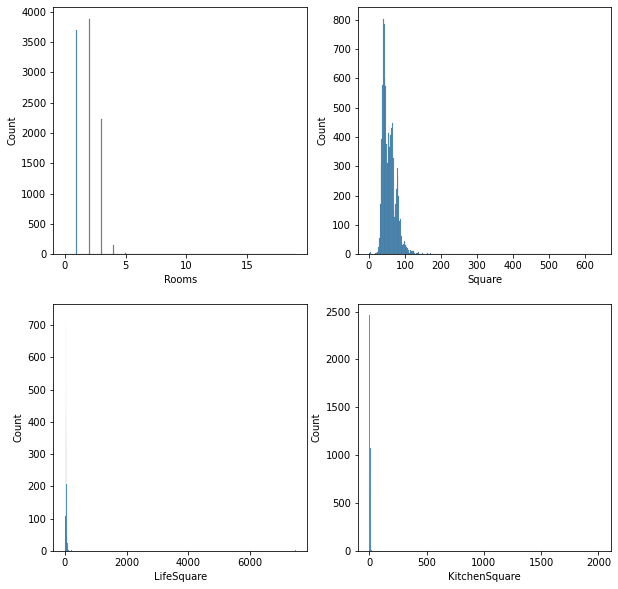

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

# массив вещественных признаков
quantitative = \
[i for i in train_dataframe.columns.values if train_dataframe[i].dtype.name != 'category' and i != 'Price' ]

quantitative
def show_partly(variables, N1, N2):
    fig,axes = plt.subplots(N1,N2)
    fig.set_size_inches(10, 10)
    for i, elem in enumerate(variables):
         sns.histplot(train_dataframe[elem], ax=axes[i // N1, i % N2])
        
show_partly(quantitative[:4], 2, 2)

##### По рядам Rooms, Square, LifeSquare, KitchenSquare есть аномально высокие значения. Заметим, что, квартир с числом комнат > 5 или == 0 мало, то есть будем считать адекватным количество комнат от 1 до 5 включительно. Попробуем заменить выбросы (не путать с недостающими значениями) на медианные значения.

In [10]:
condition_rooms = (train_dataframe['Rooms'] > 5) | (train_dataframe['Rooms'] <= 0)
train_dataframe.loc[condition_rooms, 'Rooms'] = train_dataframe['Rooms'].median()


##### Значения переменных площади (LifeSquare, Square, KitchenSquare), выше 99%-го квартиля, попробуем заменить на медианные.

In [11]:
for square in ['LifeSquare', 'Square', 'KitchenSquare']:
    condition = (train_dataframe[square] > train_dataframe[square].quantile(0.99))
    train_dataframe.loc[condition, square] = train_dataframe[square].median()

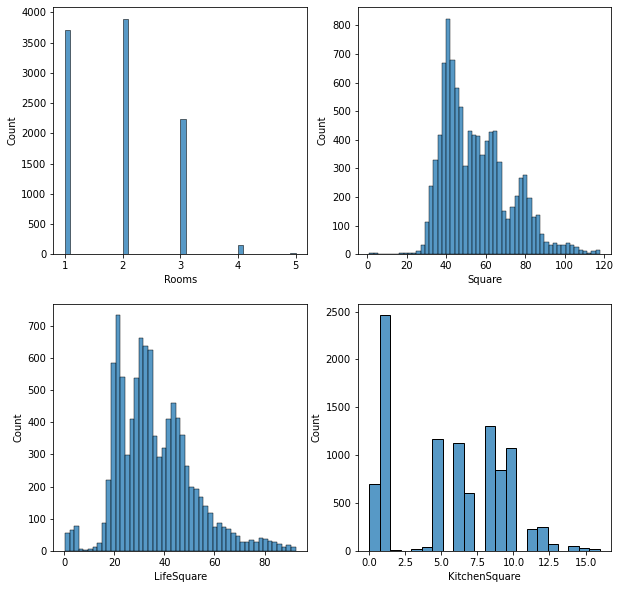

In [12]:
# смотрим на данные ещё раз
show_partly(quantitative[:4], 2, 2)

#### Воспользуемся некоторыми практическими соображениями и улучшим данные по площадям:
##### 1. Установим минимальную общую площадь на уровне 20 квадратных метров (примерно соответствует студии), то есть минимальный порог жилой площади = 20 квадратных метров;
##### 2. Установим порог минимальной площади кухни на уровне 5 квадратных метров;
##### 3. Установим порог жилой площади как 20 * 0.66 = 13.2 м

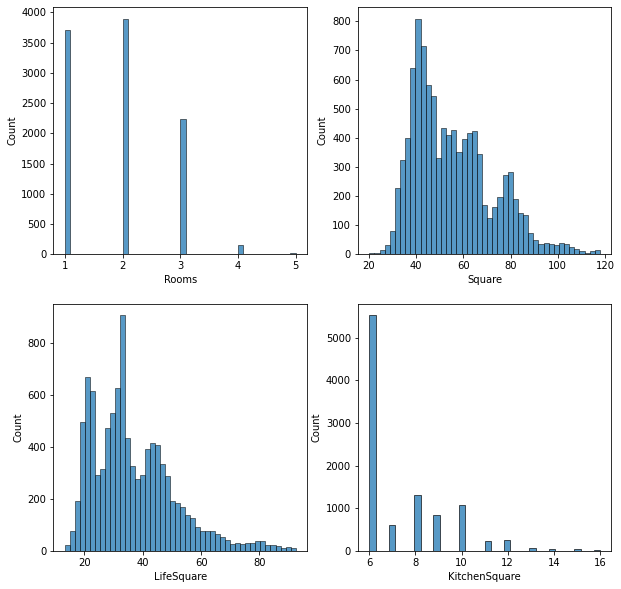

In [13]:
conditions = {
    'Square' : train_dataframe['Square'] <= 20,
    'KitchenSquare' : train_dataframe['KitchenSquare'] <= 5,
    'LifeSquare' : train_dataframe['LifeSquare'] <= 13.2
}

for square in ['LifeSquare', 'Square', 'KitchenSquare']:
    train_dataframe.loc[conditions[square], square] = train_dataframe[square].median()
    
show_partly(quantitative[:4], 2, 2)

##### Рассмотрим данные по возрасту домов:

In [14]:
max, min = train_dataframe['HouseYear'].max(), train_dataframe['HouseYear'].min()
print(max, min)

20052011 1910


##### Обнаружено неадекватное максимальное значение. Заменим все значения > 2021 на медианные.

In [15]:
train_dataframe.loc[train_dataframe['HouseYear'] > 2021, 'HouseYear'] = train_dataframe['HouseYear'].median()

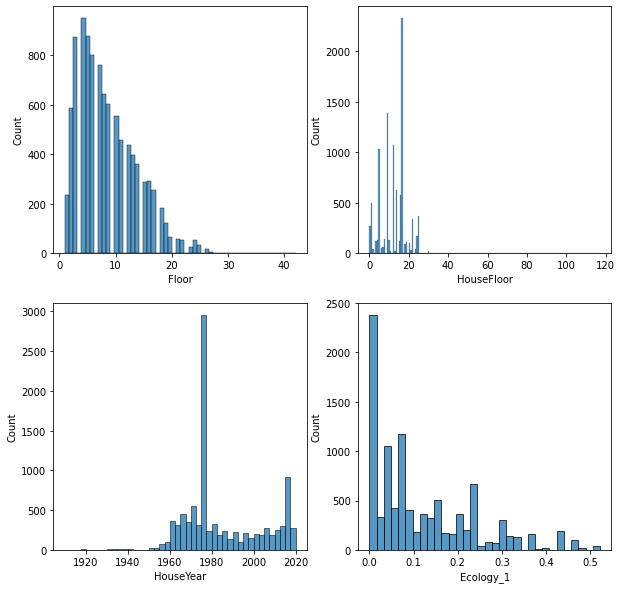

In [16]:
show_partly(quantitative[4:8], 2, 2)

##### Присутствуют явные выбросы в столбцах HouseFloor, Floor. Ограничим их оба значениями 30, выпавшие значения приравняем к медианам.  Максимум в окошке HouseYear, возможно, можно связать со строительным бумом в 70-х - 80-х гг, когда после хрущёвок начали активно застраивать панельные дома. Поэтому данный пик проигнорирован и оставлен как есть.

In [17]:
train_dataframe.loc[train_dataframe['Floor'] > 30, 'Floor'] = train_dataframe['Floor'].median()
train_dataframe.loc[train_dataframe['HouseFloor'] > 30, 'HouseFloor'] = train_dataframe['HouseFloor'].median()

##### Рассмотрим данные повторно. Получилась более приемлемая картина.

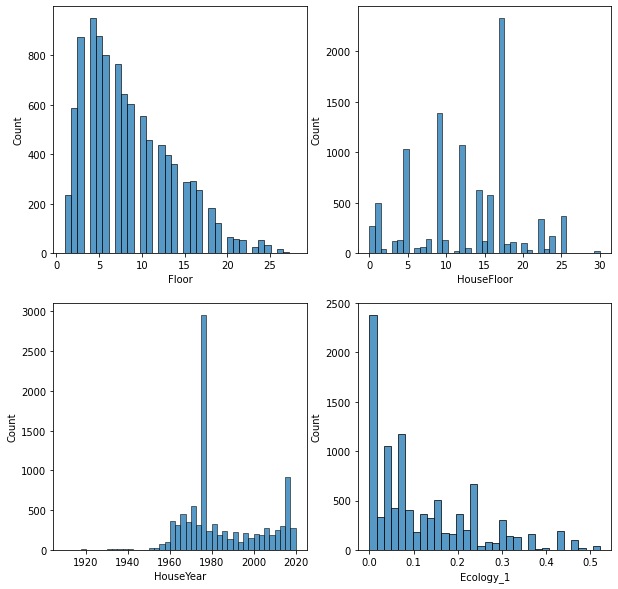

In [18]:
show_partly(quantitative[4:8], 2, 2)

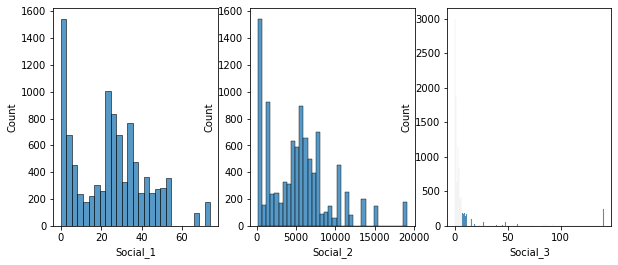

In [19]:
def show_partly_social(variables):
    fig,axes = plt.subplots(1,3)
    fig.set_size_inches(10, 4)
    for i, elem in enumerate(variables):
         sns.histplot(train_dataframe[elem], ax=axes[i])
        
show_partly_social(quantitative[8:11])

* По критерию Social_1 имеются выбросы. Порог > 60
* По критерию Social_2 выбросы имеют порог ~ > 16000
* По критерию Social_3 выбросы имеют порог ~ > 20

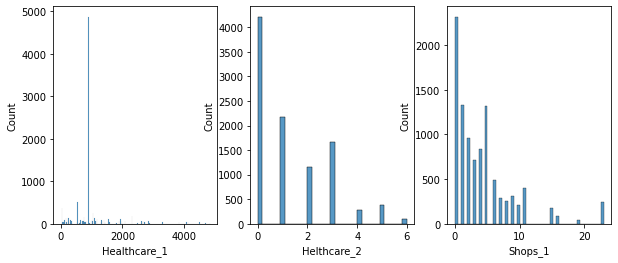

In [20]:
show_partly_social(quantitative[11:14])

* По критерию Healthcare_1, возможно, выбросы при значениях > 2000
* По критерию Shops_1 выбросы имеют порог ~ > 20

In [21]:
conditions2 = {
    'Social_1' : train_dataframe['Social_1'] > 60,
    'Social_2' : train_dataframe['Social_2'] > 16000,
    'Social_3' : train_dataframe['Social_3'] > 20,
#     'Healthcare_1': (train_dataframe['Healthcare_1'] > 2000) | (train_dataframe['Healthcare_1'] < 700),
    'Shops_1': train_dataframe['Shops_1'] > 20
}

for col in conditions2.keys():
    train_dataframe.loc[conditions2[col], col] = train_dataframe[col].median()

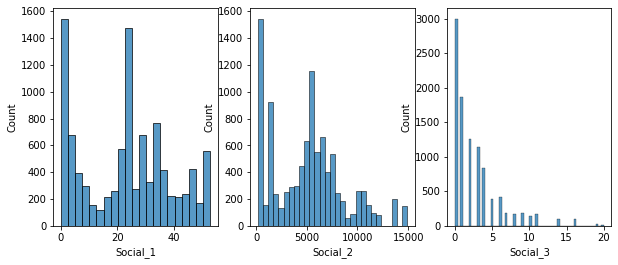

In [22]:
show_partly_social(quantitative[8:11])

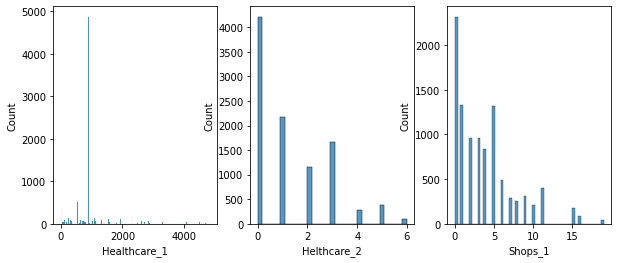

In [23]:
show_partly_social(quantitative[11:14])

#### Параметр Healthcare_1 оставим нетронутым. Сохраним полученные данные.

In [24]:
train_dataframe.to_pickle('data_backup_1.pkl')

#### Поробуем перевести категориальные переменные в вещественные:

In [25]:
# new_df  = pd.read_pickle('data_backup_1.pkl')
# district_size = new_df['DistrictId'].value_counts().reset_index().rename(columns = {'index': 'DistrictId', 'DistrictId':'DistrictSize'})

# 3. Оформим задачу как положено. Воспользуемся ранее полученной информацией и организуем хорошую предобработку данных:

In [26]:
class DataPreprocessing:

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.99)
        self.square_quantile = X['Square'].quantile(.99)
        self.life_square_quantile = X['LifeSquare'].quantile(.99)
    
    def transform(self, X):
        
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)
#         reduce_mem_usage(X)
        
        AVG_LIFESQ_SHARE = 0.6658
        """Трансформация данных"""
#       данные пороги вещественных переменных грубо подобраны в ходе EDA
        conditions = {

            'Rooms' : (X['Rooms'] > 5) | (X['Rooms'] <= 0),
            'Healthcare_1' : X['Healthcare_1'].isna(),
            'Square' : (X['Square'] <= 20) | (X['Square'] > self.square_quantile),
            'KitchenSquare' : (X['KitchenSquare'] <= 5) | (X['KitchenSquare'] > self.kitchen_square_quantile),
            'LifeSquare' : (X['LifeSquare'] <= 13.2) | (X['LifeSquare'] > self.life_square_quantile) \
            | (X['LifeSquare'].isna()),
            'HouseYear' : X['HouseYear'] > 2021,
            'Social_1' : X['Social_1'] > 60,
            'Social_2' : X['Social_2'] > 16000,
            'Social_3' : X['Social_3'] > 20,
            'Shops_1': X['Shops_1'] > 20
        }
        # Rooms
        for col in conditions.keys():
            if col != 'LifeSquare':
                X.loc[conditions[col], col] = self.medians[col]
            else:
                X.loc[conditions[col], col] = X['Square'] * AVG_LIFESQ_SHARE   
        
        return X

# 4. Выполним генерацию фич:

* на основании district id указать условный размер района
* на основании district_id указать, большой район или маленький
* средний размер кухни
* перевести классы экологии и тому подобные величины в числовые (например, {'A' : 0, 'B' : 1})
* оценить эпоху дома (возраст дома)

##### Взял за основу ваш класс FeatureGenetator и переделал его под свои нужды:

In [27]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
#         self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.district_size = None
        self.house_year_min = None
        self.house_year_max = None
        self.avg_kitchen_square = None
        
        
        self.med_price_by_district = None
        self.med_price_by_floor_year = None

        
    def fit(self, X):
        X = X.copy()
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        self.house_year_min = X['HouseYear'].min()
        self.house_year_max = X['HouseYear'].max()
        
        # AvgKitchenSize        
        self.avg_kitchen_square = X.groupby(['DistrictId']).mean(['KitchenSquare'])['KitchenSquare'].reset_index()\
        .rename(columns={'index':'DistrictId', 'KitchenSquare' : 'AvgKitchenSquare'})

    def transform(self, X):
        
        X = X.copy()

        # DistrictId, IsDistrictLarge, AvgKitchenSize - оставим как есть
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X = X.merge(self.avg_kitchen_square, on = 'DistrictId', how = 'left')
        
        # анализ размера района 
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        # Binary features - оставим как есть
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        X = self.year_to_cat(X)
        
        return X
    
    def year_to_cat(self,X):

        bins = [self.house_year_min, 1920, 1940, 1960, 1980, 2000, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
    
        return X

# 5. Обучение моделей

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

preprocessor = DataPreprocessing()

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

reduce_mem_usage(train_df)
reduce_mem_usage(test_df)

preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

TARGET_NAME = 'Price'
X = train_df.drop(columns = TARGET_NAME)
y = train_df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.30, shuffle = True, random_state = 74)

# preprocessor.fit(X_train)
# X_train = preprocessor.transform(X_train)
# X_valid = preprocessor.transform(X_valid)

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()
# X_train.shape, X_valid.shape, test_df.shape

# features_gen = FeatureGenerator()
# features_gen.fit(X_train)

# test_df.shape
test_df.fillna(0, inplace = True)
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


(0, 0, 0)

##### Здесь различным образом игрался с GridSearchCV, чтобы понять, как лучше обучать модель.

In [29]:
# parameters = {
#     'max_features': np.arange(15, 20),
#     'max_depth': np.arange(3, 7),
# }

# clf = GridSearchCV(
#     estimator=RandomForestRegressor(),
#     param_grid=parameters,
#     scoring='r2',
#     cv=7,
# )

# clf.fit(X_train, y_train)
# clf.best_params_
# {'max_depth': 6, 'max_features': 17}



##### Модель обучения: случайный лес, глубина 7, 19 признаков.

In [30]:
regr = RandomForestRegressor(max_depth=7, max_features = 19, random_state=74)
regr.fit(X_train, y_train)

# cv_results = pd.DataFrame(clf.cv_results_)
# cv_results.columns.params

print(regr.score(X_train, y_train))
print(regr.score(X_valid, y_valid))

0.7595621349321223
0.6913239831068885


In [31]:
# test_df
# y_test_preds
y_test_preds = regr.predict(test_df)
# y_test_preds
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()
submit['Price'] = y_test_preds

submit.to_csv('rf2_submit.csv', index=False)

# submit.head()

# Используемые библиотеки

In [32]:
!pip freeze >> requirements.txt

<!-- Используемые библиотеки  -->